<a href="https://colab.research.google.com/github/GeneSUN/Anomaly_Detection_toolkit/blob/main/Proximity_Based_Anomaly_Detection_in_Multivariate_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1152466050.py:67: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pd.date_range(config.start, periods=T, freq=config.freq)


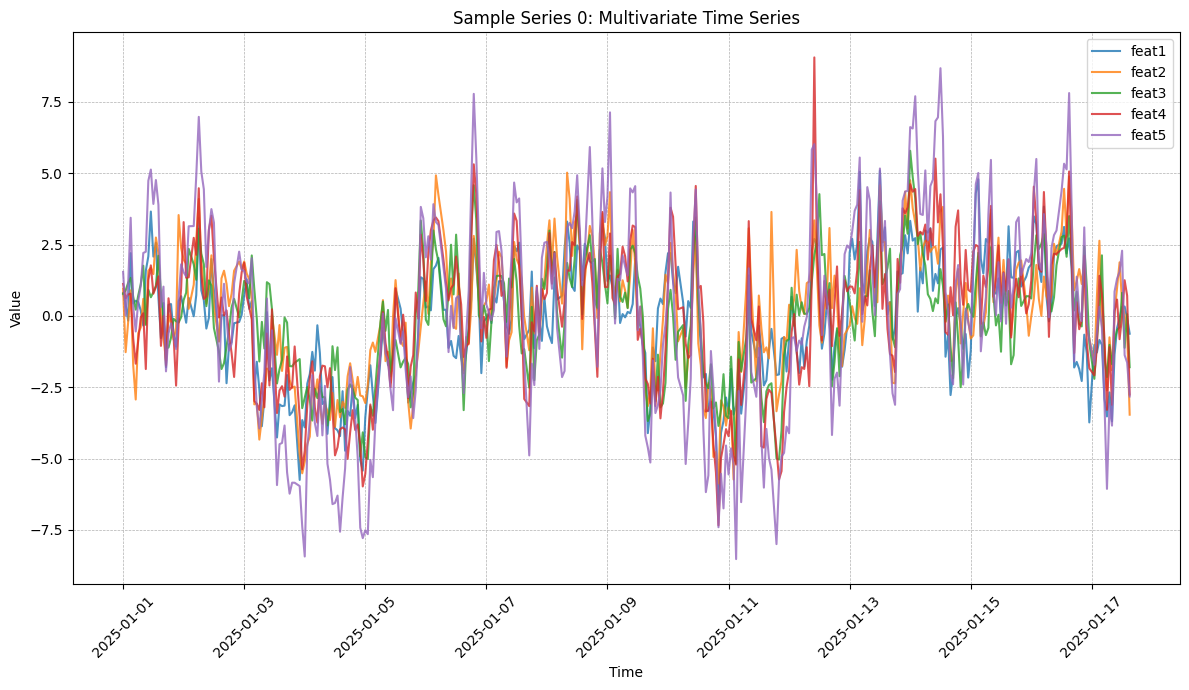

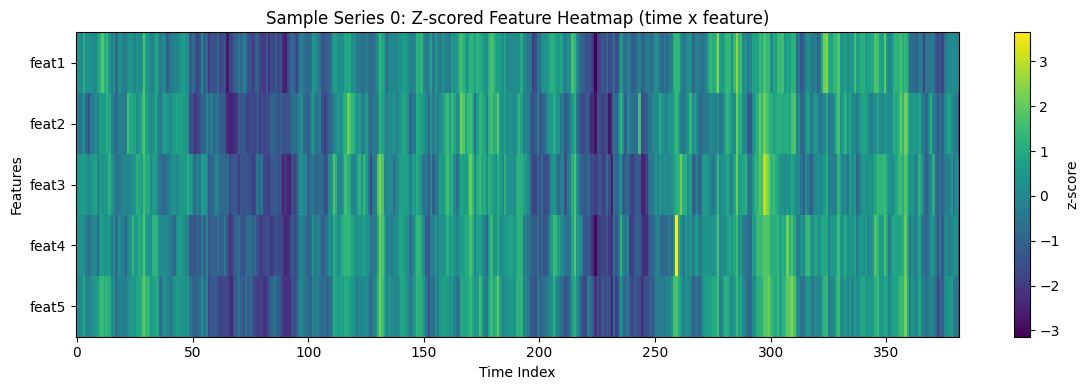

In [ ]:
#@title Multivariate time series
# Synthetic "real-world" multivariate time series generator
# - Correlated features via latent factors
# - Trend + seasonality + AR(1) noise
# - Regime shifts & change points
# - Point spikes, variance bursts, and level-shift anomalies (with labels)
# - Random & block missingness
#
# Produces long-format DataFrame with columns:
# ['series_id','time','feature','value','is_anomaly','anomaly_type']

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass, asdict
from typing import List, Dict, Optional, Tuple
from itertools import product
import uuid

rng = np.random.default_rng(42)

@dataclass
class SynthConfig:
    n_series: int = 50                 # number of distinct entities (e.g., users/sensors)
    n_features: int = 5                # number of features per entity
    periods: int = 500                 # length per series
    freq: str = "H"                    # pandas frequency alias
    start: str = "2024-01-01"          # start timestamp
    trend_strength: float = 0.002      # linear trend magnitude
    weekly_season_amp: float = 2.0     # amplitude of weekly seasonality
    daily_season_amp: float = 1.0      # amplitude of daily seasonality
    ar_coef: float = 0.6               # AR(1) coefficient
    noise_scale: float = 0.8           # base noise std
    latent_factor_scale: float = 1.5   # scale for shared latent factor
    level_shift_prob: float = 0.05     # probability a series has a regime shift
    level_shift_scale: float = 2.5     # magnitude of regime shift
    point_anom_prob: float = 0.005     # probability per point of spike
    point_anom_scale: float = 6.0      # spike std multiplier
    burst_prob: float = 0.03           # probability of a variance burst window
    burst_len: Tuple[int,int] = (12, 48)  # min/max length of variance burst
    missing_prob: float = 0.01         # random missing per point
    missing_block_prob: float = 0.03   # probability of a missing block
    missing_block_len: Tuple[int,int] = (6, 24) # min/max missing block len
    seed: Optional[int] = 42

def _seasonal(t_index: pd.DatetimeIndex, daily_amp: float, weekly_amp: float) -> np.ndarray:
    # daily seasonality using 24h
    day_phase = 2*np.pi*(t_index.hour + t_index.minute/60)/24
    daily = daily_amp*np.sin(day_phase) + 0.5*daily_amp*np.cos(2*day_phase)
    # weekly seasonality using 7d
    week_phase = 2*np.pi*(t_index.dayofweek*24 + t_index.hour)/ (7*24)
    weekly = weekly_amp*np.sin(week_phase) + 0.5*weekly_amp*np.cos(2*week_phase)
    return daily + weekly

def _make_latent_factor(T: int, ar: float, scale: float, noise_scale: float, season: np.ndarray, trend_strength: float) -> np.ndarray:
    z = np.zeros(T)
    eps = rng.normal(0, noise_scale, T)
    for t in range(1, T):
        z[t] = ar*z[t-1] + eps[t]
    t_idx = np.arange(T)
    trend = trend_strength*(t_idx - T/2)
    return scale*z + season + trend

def synthesize_multivar(config: SynthConfig) -> pd.DataFrame:
    rng = np.random.default_rng(config.seed)
    T = config.periods
    time_index = pd.date_range(config.start, periods=T, freq=config.freq)

    # global seasonal pattern
    season = _seasonal(time_index, config.daily_season_amp, config.weekly_season_amp)

    records = []
    for sid in range(config.n_series):
        # latent factor for correlation across features within a series
        latent = _make_latent_factor(
            T=T, ar=config.ar_coef, scale=config.latent_factor_scale,
            noise_scale=config.noise_scale, season=season,
            trend_strength=config.trend_strength * rng.uniform(0.5, 1.5)
        )

        # optional level shift (regime change) per series
        level_shift = np.zeros(T)
        if rng.random() < config.level_shift_prob:
            cp = rng.integers(int(0.3*T), int(0.8*T))
            shift_mag = rng.normal(config.level_shift_scale, 0.5)
            level_shift[cp:] += shift_mag

        # variance burst window
        burst_mask = np.zeros(T, dtype=bool)
        if rng.random() < config.burst_prob:
            L = rng.integers(config.burst_len[0], config.burst_len[1]+1)
            s = rng.integers(int(0.1*T), int(0.9*T)-L)
            burst_mask[s:s+L] = True

        # feature-specific weights to the latent factor and own AR(1)
        W = rng.normal(1.0, 0.3, config.n_features)  # loading weights

        for f in range(config.n_features):
            # AR(1) idiosyncratic
            eps = rng.normal(0, config.noise_scale, T)
            x = np.zeros(T)
            for t in range(1, T):
                # noise inflation during bursts
                sigma_t = config.noise_scale*(3.0 if burst_mask[t] else 1.0)
                eps_t = rng.normal(0, sigma_t)
                x[t] = config.ar_coef*x[t-1] + eps_t

            # feature value = latent loading + idiosyncratic + level shift
            values = W[f]*latent + x + level_shift

            # point anomalies (spikes)
            anom_mask = rng.random(T) < config.point_anom_prob
            values = values + anom_mask * rng.normal(0, config.point_anom_scale*config.noise_scale, T)

            # missingness
            miss_mask = rng.random(T) < config.missing_prob
            # block missing
            if rng.random() < config.missing_block_prob:
                Lm = rng.integers(config.missing_block_len[0], config.missing_block_len[1]+1)
                sm = rng.integers(int(0.05*T), int(0.95*T)-Lm)
                miss_mask[sm:sm+Lm] = True

            # anomaly labels
            is_anom = anom_mask | burst_mask | (level_shift != 0)

            rec = pd.DataFrame({
                "series_id": sid,
                "time": time_index,
                "feature": f"feat{f+1}",
                "value": values,
                "is_anomaly": is_anom,
                "anomaly_type": np.where(anom_mask, "point_spike",
                                  np.where(burst_mask, "variance_burst",
                                  np.where(level_shift!=0, "level_shift", "normal")))
            })
            # apply missing
            rec.loc[miss_mask, "value"] = np.nan
            records.append(rec)

    df_long = pd.concat(records, ignore_index=True)
    return df_long

# --- Generate a sample dataset ---
config = SynthConfig(
    n_series=20,
    n_features=5,
    periods=400,
    freq="H",
    start="2025-01-01",
    seed=7
)
df = synthesize_multivar(config)
df = df.dropna(subset=["value"]).reset_index(drop=True)

# Save to CSV
#path = "/mnt/data/synth_multivar_timeseries_long.csv"
#df.to_csv(path, index=False)

# Quick visual: one series across all features
sample_id = df["series_id"].iloc[0]
subset = (
    df[df["series_id"] == sample_id]
    .pivot_table(index="time", columns="feature", values="value")
    .reset_index()  # keep 'time' as a normal column
)
subset= subset.dropna(subset=["feat1","feat2","feat3","feat4","feat5",]).reset_index(drop=True)

plt.figure(figsize=(12,7))

# plot each feature against time
for col in subset.columns:
    if col != "time":  # skip the time column
        plt.plot(subset["time"], subset[col], label=col, alpha=0.8)

plt.title(f"Sample Series {sample_id}: Multivariate Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.xticks(rotation=45)  # rotate ticks for readability
plt.tight_layout()
plt.show()


# Quick anomaly heatmap-like view (matplotlib imshow since seaborn is disallowed)
# Build matrix: time x feature (normalize for visibility)
mat = subset.drop(columns=["time"]).copy()
mat = (mat - mat.mean()) / mat.std()

plt.figure(figsize=(12,4))
plt.imshow(mat.T, aspect='auto', interpolation='nearest')
plt.title(f"Sample Series {sample_id}: Z-scored Feature Heatmap (time x feature)")
plt.yticks(range(len(mat.columns)), mat.columns)
plt.xlabel("Time Index")
plt.ylabel("Features")
plt.colorbar(label="z-score")
plt.tight_layout()
plt.show()




In [ ]:
subset.head(3)

feature,time,feat1,feat2,feat3,feat4,feat5
0,2025-01-01 00:00:00,0.805261,0.948964,0.771948,1.118675,1.540657
1,2025-01-01 01:00:00,0.416419,-1.271379,0.891167,0.611352,0.018595
2,2025-01-01 02:00:00,-0.167241,-0.219730,1.158428,0.754141,1.128631


# Single Model

In [ ]:
#@title KMeansOutlierDetector
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors

# ==============================================================
# Base Detector
# ==============================================================

class BaseOutlierDetector:
    def __init__(self, df, features, time_col="time", scale=True,
                 filter_percentile=None, threshold_percentile=99):
        self.df = df.copy()
        self.features = features
        self.time_col = time_col
        self.scale = scale
        self.filter_percentile = filter_percentile
        self.threshold_percentile = threshold_percentile

        self.scaler = StandardScaler() if scale else None
        self.fitted = False
        self.df_clean = self.preprocess(self.df)

    def preprocess(self, df):
        X = df[self.features].values

        # Optional filter extremes
        if self.filter_percentile is not None:
            center = np.mean(X, axis=0)
            dists = np.linalg.norm(X - center, axis=1)
            lower = np.percentile(dists, self.filter_percentile)
            upper = np.percentile(dists, 100 - self.filter_percentile)
            mask = (dists >= lower) & (dists <= upper)
            df = df.loc[mask]

        if self.scale:
            X = self.scaler.fit_transform(df[self.features].values)
            df[self.features] = X

        return df.reset_index(drop=True)

    def plot(self):
        if not self.fitted:
            raise RuntimeError("Model must be fitted before plotting.")

        X = self.df_clean[self.features].values
        scores = self.df_clean["outlier_score"].values
        is_outlier = self.df_clean["is_outlier"].values

        # Choose raw vs PCA
        if len(self.features) == 2:
            X_plot = X
            title_suffix = "(2D Features)"
        else:
            print(f"[INFO] {len(self.features)} features detected. Using PCA projection to 2D.")
            X_plot = PCA(n_components=2).fit_transform(X)
            title_suffix = "(PCA Reduced)"

        vmin, vmax = scores.min(), scores.max()
        fig, ax = plt.subplots(figsize=(8, 6))

        # Inliers
        ax.scatter(X_plot[~is_outlier, 0], X_plot[~is_outlier, 1],
                   c=scores[~is_outlier], cmap="coolwarm", s=50,
                   edgecolors="none", vmin=vmin, vmax=vmax, label="Inliers")

        # Outliers
        ax.scatter(X_plot[is_outlier, 0], X_plot[is_outlier, 1],
                   c=scores[is_outlier], cmap="coolwarm", s=50,
                   edgecolors="black", linewidths=1, vmin=vmin, vmax=vmax, label="Outliers")

        # Colorbar + labels
        cb = plt.colorbar(ax.collections[0], ax=ax)
        cb.set_label("Outlier Score")
        ax.set_title(f"{self.__class__.__name__} Detection {title_suffix}")
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.legend()
        plt.tight_layout()
        plt.show()

    def plot_line(self, feature=None):
        if not self.fitted:
            raise RuntimeError("Model must be fitted before plotting.")
        if feature is None:
            feature = self.features[0]
        if self.time_col not in self.df.columns:
            raise ValueError(f"time_col '{self.time_col}' not found in input df.")
        if feature not in self.df.columns:
            raise ValueError(f"Feature '{feature}' not found in df.")

        merged_df = self.df[[self.time_col, feature]].merge(
            self.df_clean[[self.time_col, "is_outlier"]],
            on=self.time_col, how="left"
        ).sort_values(self.time_col)

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(merged_df[self.time_col], merged_df[feature], color="blue", label=feature)
        ax.scatter(merged_df[merged_df["is_outlier"]][self.time_col],
                   merged_df[merged_df["is_outlier"]][feature],
                   color="red", label="Outlier", zorder=5)
        ax.set_xlabel(self.time_col)
        ax.set_ylabel(feature)
        ax.set_title(f"{feature} over Time with Outliers ({self.__class__.__name__})")
        ax.legend()
        plt.tight_layout()
        plt.show()

    def plot_radar(self, point_idx=None, agg="median", lower_q=25, upper_q=75):
        """
        Plot a radar chart comparing one outlier point against the majority distribution.

        Parameters
        ----------
        point_idx : int, optional
            Index of the point in df_clean to highlight. If None, the first outlier is used.
        agg : {'mean','median'}, default='median'
            Aggregation for majority profile.
        lower_q : float, default=25
            Lower percentile for variability band.
        upper_q : float, default=75
            Upper percentile for variability band.
        """
        if not self.fitted:
            raise RuntimeError("Model must be fitted before plotting.")

        features = self.features
        n_features = len(features)

        # Majority profile
        normal_df = self.df_clean[~self.df_clean["is_outlier"]][features]
        if agg == "mean":
            majority = normal_df.mean().values
        else:
            majority = normal_df.median().values

        # Variability band
        q_low = normal_df.quantile(lower_q / 100.0).values
        q_high = normal_df.quantile(upper_q / 100.0).values

        # Outlier point
        if point_idx is None:
            outlier_row = self.df_clean[self.df_clean["is_outlier"]].iloc[0]
        else:
            outlier_row = self.df_clean.iloc[point_idx]
        outlier = outlier_row[features].values

        # Radar chart setup
        angles = np.linspace(0, 2*np.pi, n_features, endpoint=False).tolist()
        angles += angles[:1]  # close the circle

        fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))

        # Majority profile
        majority_vals = majority.tolist() + majority[:1].tolist()
        ax.plot(angles, majority_vals, color="grey", linewidth=2, label=f"Majority ({agg})")
        ax.fill(angles, majority_vals, color="grey", alpha=0.2)

        # Variability band (percentiles)
        q_low_vals = q_low.tolist() + q_low[:1].tolist()
        q_high_vals = q_high.tolist() + q_high[:1].tolist()
        ax.fill_between(angles, q_low_vals, q_high_vals,
                        color="grey", alpha=0.1,
                        label=f"{lower_q}–{upper_q} percentile band")

        # Outlier
        outlier_vals = outlier.tolist() + outlier[:1].tolist()
        ax.plot(angles, outlier_vals, color="red", linewidth=2, label="Outlier")
        ax.fill(angles, outlier_vals, color="red", alpha=0.1)

        # Feature labels
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(features)

        plt.title("Radar Chart: Outlier vs Majority Profile", pad=20)

        ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
        plt.show()

    def fit(self):
        raise NotImplementedError


# ==============================================================
# KMeans Detector
# ==============================================================

class KMeansOutlierDetector(BaseOutlierDetector):
    def __init__(self, df, features, time_col="time", n_clusters=2,
                 distance_metric="euclidean", random_state=42,
                 scale=True, filter_percentile=None, threshold_percentile=99):
        super().__init__(df, features, time_col, scale, filter_percentile, threshold_percentile)
        self.n_clusters = n_clusters
        self.distance_metric = distance_metric
        self.random_state = random_state
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        self.centers = None
        self.cov_inv = None

    def _compute_distance(self, X, centers, labels):
        if self.distance_metric == "euclidean":
            return np.linalg.norm(X - centers[labels], axis=1)
        elif self.distance_metric == "manhattan":
            return np.sum(np.abs(X - centers[labels]), axis=1)
        elif self.distance_metric == "mahalanobis":
            if self.cov_inv is None:
                cov = np.cov(X.T)
                self.cov_inv = np.linalg.pinv(cov)
            d = []
            for x, center in zip(X, centers[labels]):
                diff = x - center
                dist = np.sqrt(diff.T @ self.cov_inv @ diff)
                d.append(dist)
            return np.array(d)
        else:
            raise ValueError(f"Unsupported distance metric: {self.distance_metric}")

    def fit(self):
        X = self.df_clean[self.features].values
        self.kmeans.fit(X)
        labels = self.kmeans.labels_
        self.centers = self.kmeans.cluster_centers_
        distances = self._compute_distance(X, self.centers, labels)
        self.scores = self.df_clean["outlier_score"] = distances

        threshold = np.percentile(distances, self.threshold_percentile)
        self.is_outlier =  self.df_clean["is_outlier"] = distances >= threshold

        self.fitted = True




[INFO] 5 features detected. Using PCA projection to 2D.


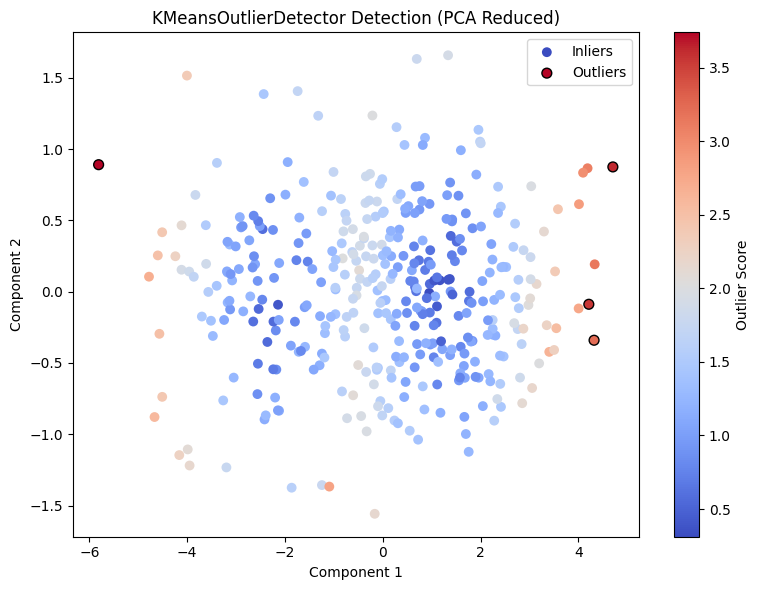

In [ ]:
# Use the provided class definition
kmeans_det = KMeansOutlierDetector(
        df=subset,
        features=["feat1", "feat2", "feat3", "feat4","feat5"],
        n_clusters=2,
        scale=True,
        threshold_percentile=99,
        time_col="time"
    )

kmeans_det.fit()
kmeans_det.plot()


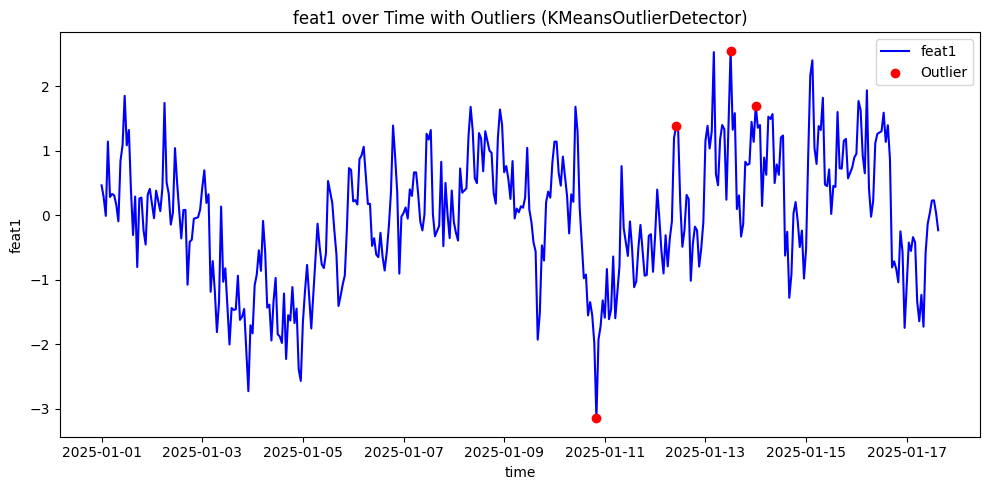

In [ ]:
kmeans_det.plot_line(  )

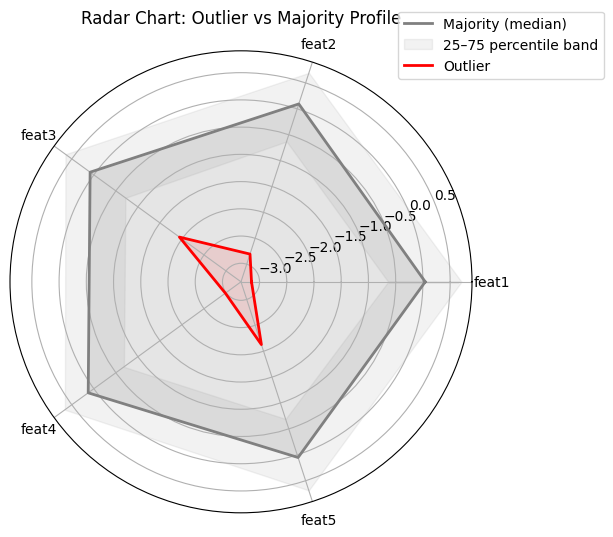

In [ ]:
kmeans_det.plot_radar()

## Other Models

In [ ]:

# ==============================================================
# LOF Detector
# ==============================================================

class LOFOutlierDetector(BaseOutlierDetector):
    def __init__(self, df, features, time_col="time", contamination=0.05,
                 scale=True, filter_percentile=None, threshold_percentile=99):
        super().__init__(df, features, time_col, scale, filter_percentile, threshold_percentile)
        self.contamination = contamination
        self.model = LocalOutlierFactor(n_neighbors=20, contamination=contamination)

    def fit(self):
        X = self.df_clean[self.features].values
        y_pred = self.model.fit_predict(X)
        self.scores = -self.model.negative_outlier_factor_

        self.df_clean["outlier_score"] = self.scores
        self.is_outlier  = self.df_clean["is_outlier"] = y_pred == -1
        self.fitted = True


# ==============================================================
# kNN Detector
# ==============================================================

class KNNOutlierDetector(BaseOutlierDetector):
    def __init__(self, df, features, time_col="time", k=5, method="kth",
                 scale=True, filter_percentile=None, threshold_percentile=99):
        super().__init__(df, features, time_col, scale, filter_percentile, threshold_percentile)
        self.k = k
        self.method = method

    def fit(self):
        X = self.df_clean[self.features].values
        nn = NearestNeighbors(n_neighbors=self.k + 1).fit(X)
        distances, _ = nn.kneighbors(X)
        dists = distances[:, 1:]  # exclude self

        if self.method == "kth":
            scores = dists[:, -1]
        elif self.method == "average":
            scores = dists.mean(axis=1)
        elif self.method == "harmonic":
            scores = self.k / np.sum(1.0 / dists, axis=1)
        else:
            raise ValueError(f"Unknown method {self.method}")

        self.scores = self.df_clean["outlier_score"] = scores
        threshold = np.percentile(scores, self.threshold_percentile)
        self.is_outlier = self.df_clean["is_outlier"] = scores >= threshold
        self.fitted = True

# Ensemble Method

In [ ]:
#@title EnsembleOutlierDetector
class EnsembleOutlierDetector(BaseOutlierDetector):
    def __init__(self, df, detectors, method='average_score', weights=None, threshold=0.5):
        """
        Ensemble Outlier Detector.

        Parameters
        ----------
        detectors : list
            List of fitted detector objects (each must be a child of BaseOutlierDetector).
        method : str
            {'majority_vote', 'weighted_vote', 'average_score', 'max_score'}.
        weights : list of float
            Same length as detectors. Used for weighted methods.
        threshold : float
            Threshold for deciding outliers in voting/score methods.
        """
        # Initialize BaseOutlierDetector with a dummy df & features
        # Will be replaced once we aggregate from detectors
        self.df = df.copy()

        self.detectors = detectors
        self.method = method
        self.weights = weights or [1.0] * len(detectors)
        assert len(self.weights) == len(detectors), "Weights must match detectors"
        self.threshold = threshold

        self.detector_names = [det.__class__.__name__ for det in detectors]
        self.fitted = False

    def fit(self):
        # Assume all detectors are already fitted on the same df
        for det in self.detectors:
            if not det.fitted:
                det.fit()

        # Use df_clean from the first detector as reference
        base_df = self.detectors[0].df_clean.copy()
        scores = np.vstack([det.df_clean["outlier_score"].values for det in self.detectors]).T
        labels = np.vstack([det.df_clean["is_outlier"].values for det in self.detectors]).T

        # Normalize scores per detector
        norm_scores = np.zeros_like(scores, dtype=float)
        for j in range(scores.shape[1]):
            s = scores[:, j]
            min_s, max_s = np.min(s), np.max(s)
            if max_s > min_s:
                norm_scores[:, j] = (s - min_s) / (max_s - min_s)
            else:
                norm_scores[:, j] = 0.0

        # Combine scores/labels
        if self.method == 'average_score':
            w = np.array(self.weights) / np.sum(self.weights)
            combined = np.dot(norm_scores, w)
            is_outlier = combined >= self.threshold

        elif self.method == 'max_score':
            combined = np.max(norm_scores, axis=1)
            is_outlier = combined >= self.threshold

        elif self.method == 'majority_vote':
            votes = labels.astype(int)
            vote_sum = np.dot(votes, self.weights)
            thresh_votes = np.sum(self.weights) / 2.0
            is_outlier = vote_sum >= thresh_votes
            combined = vote_sum / np.sum(self.weights)

        elif self.method == 'weighted_vote':
            votes = labels.astype(int)
            vote_sum = np.dot(votes, self.weights)
            is_outlier = vote_sum >= self.threshold * np.sum(self.weights)
            combined = vote_sum / np.sum(self.weights)

        else:
            raise ValueError(f"Unknown ensemble method: {self.method}")

        # Store results
        base_df["outlier_score"] = combined
        base_df["is_outlier"] = is_outlier

        # Replace df_clean (so inherited plot methods work)
        self.df_clean = base_df
        self.features = self.detectors[0].features
        self.time_col = self.detectors[0].time_col
        self.fitted = True
        return self

    def plot(self):
        """Extend plot with info about ensemble composition."""
        super().plot()
        print(f"[INFO] Ensemble method: {self.method}")
        print(f"[INFO] Detectors used: {', '.join(self.detector_names)}")


In [ ]:

kmeans_det = KMeansOutlierDetector(
    df=subset,
    features=["feat1","feat2","feat3","feat4","feat5"],
    n_clusters=2,
    scale=True,
    threshold_percentile=99,
    time_col="time"
)
kmeans_det.fit()

lof_det = LOFOutlierDetector(
    df=subset,
    features=["feat1","feat2","feat3","feat4","feat5"],
    contamination=0.05,
    scale=True,
    time_col="time"
)
lof_det.fit()

knn_det = KNNOutlierDetector(
    df=subset,
    features=["feat1","feat2","feat3","feat4","feat5"],
    k=10,
    method="average",
    scale=True,
    threshold_percentile=95,
    time_col="time"
)
knn_det.fit()

[INFO] 5 features detected. Using PCA projection to 2D.


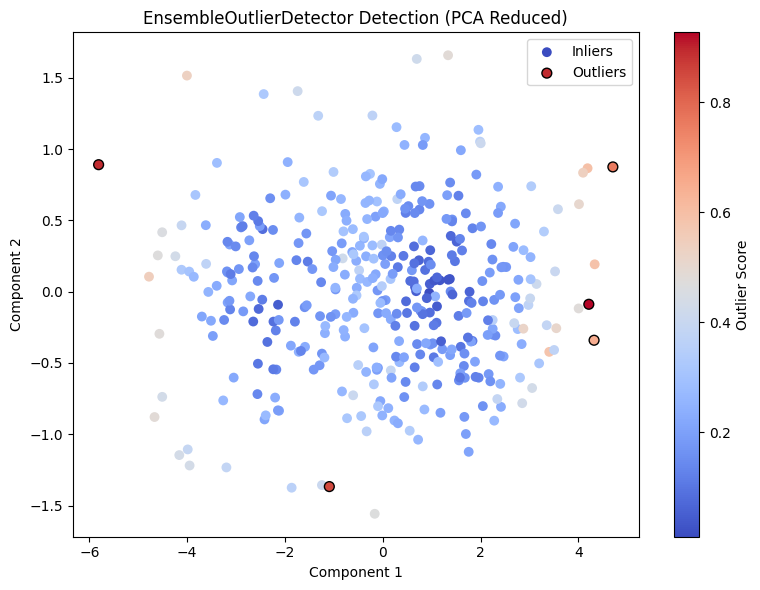

[INFO] Ensemble method: average_score
[INFO] Detectors used: KMeansOutlierDetector, LOFOutlierDetector, KNNOutlierDetector


In [ ]:
# Ensemble detector
ensemble_det = EnsembleOutlierDetector(
    df= subset,
    detectors=[kmeans_det, lof_det, knn_det],
    method="average_score",
    weights=[0.5, 0.25, 0.25],
    threshold=0.6
).fit()

# Plot results
ensemble_det.plot()

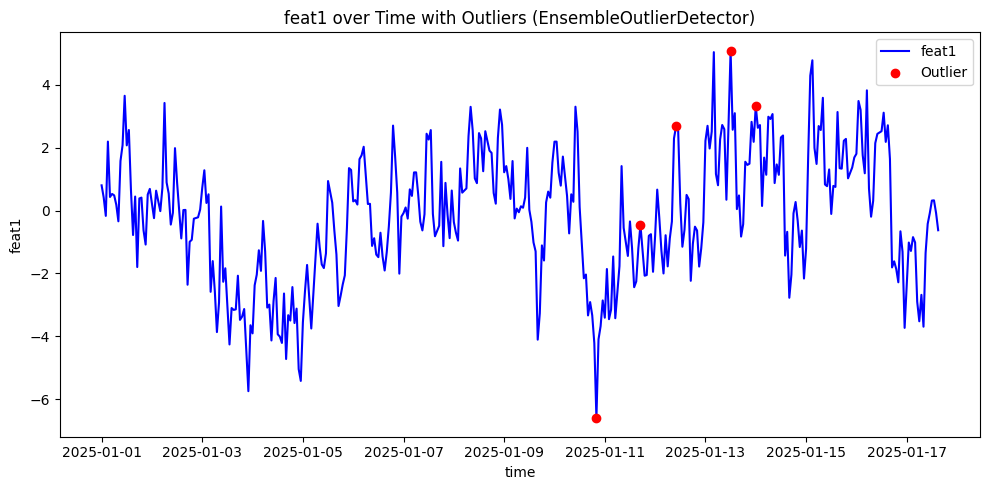

In [ ]:
ensemble_det.plot_line()

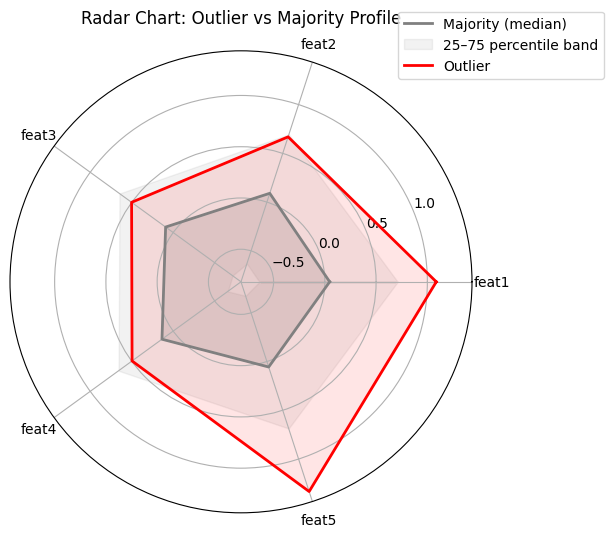

In [ ]:
ensemble_det.plot_radar(point_idx=10)

# Interpretation

In [ ]:
#@title Contribution_scores
#@markdown Outlier is flagged because its distance to the assigned cluster center is unusually large.
#@markdown
#@markdown Contribution scores tell you which features caused most of that distance.
def contribution_scores(self, point_idx):
    """
    Compute per-feature contribution to distance for a given point.

    Parameters
    ----------
    point_idx : int
        Index in df_clean of the point of interest.
    """
    if not self.fitted:
        raise RuntimeError("Model must be fitted before computing contributions.")

    row = self.df_clean.iloc[point_idx][self.features].values
    label = self.kmeans.labels_[point_idx]
    center = self.centers[label]

    if self.distance_metric == "euclidean":
        contrib = (row - center) ** 2
    elif self.distance_metric == "manhattan":
        contrib = np.abs(row - center)
    elif self.distance_metric == "mahalanobis":
        diff = row - center
        contrib = diff * (self.cov_inv @ diff)  # approx diag contributions
    else:
        raise ValueError("Unsupported distance metric.")

    return pd.Series(contrib, index=self.features)

contribution_scores

In [ ]:
#@title 2. SHAP / LIME on distance score
import shap
from shap import KernelExplainer

def explain_shap(self, sample_idx=None, nsamples=50):
    """
    Use SHAP to explain feature contributions to outlier score.

    Parameters
    ----------
    sample_idx : int, optional
        Index of the sample to explain. If None, picks first outlier.
    nsamples : int
        Number of background samples.
    """
    if not self.fitted:
        raise RuntimeError("Model must be fitted before SHAP.")

    X = self.df_clean[self.features].values
    if sample_idx is None:
        sample_idx = self.df_clean[self.df_clean["is_outlier"]].index[0]
    self.sample_idx = sample_idx
    # Wrap prediction as distance computation
    def predict_fn(X_input):
        labels = self.kmeans.predict(X_input)
        dists = self._compute_distance(X_input, self.centers, labels)
        return dists

    self.explainer = shap.KernelExplainer(predict_fn, shap.sample(X, nsamples))
    self.shap_values = self.explainer .shap_values(X[sample_idx:sample_idx+1], nsamples=nsamples)

    shap.force_plot(self.explainer.expected_value, self.shap_values, X[sample_idx], feature_names=self.features)
"""
# Use the provided class definition
kmeans_det = KMeansOutlierDetector(
        df=df,
        features=["feat1", "feat2", "feat3", "feat4","feat5"],
        n_clusters=2,
        scale=True,
        threshold_percentile=99,
        time_col="time"
    )

kmeans_det.fit()
kmeans_det.plot()
"""

import types
kmeans_det.explain_shap = types.MethodType(explain_shap, kmeans_det)

kmeans_det.explain_shap()


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
kmeans_det.shap_values

array([[0.71735364, 1.68619906, 0.86159924, 1.72220276, 0.17280677]])

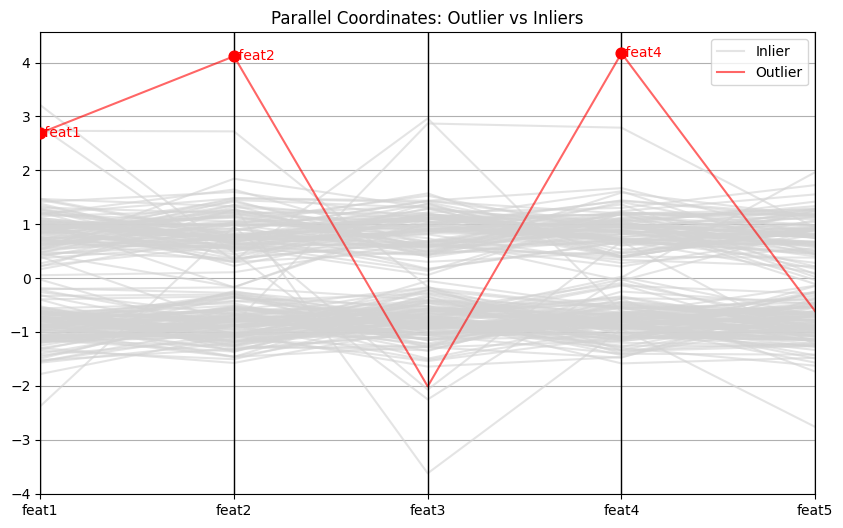

In [ ]:
#@title 3. Parallel Coordinates Plot
from pandas.plotting import parallel_coordinates
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_parallel(self, point_idx=None, sample_size=200, top_k=3):
    """
    Parallel coordinates plot comparing one outlier to sampled inliers,
    with annotations on top deviating features.

    Parameters
    ----------
    point_idx : int, optional
        Index of the outlier. If None, uses first detected outlier.
    sample_size : int
        Number of inliers to sample for visualization.
    top_k : int
        Number of largest deviations to annotate.
    """
    if not self.fitted:
        raise RuntimeError("Model must be fitted before plotting.")

    # pick outlier index
    if point_idx is None:
        point_idx = self.df_clean[self.df_clean["is_outlier"]].index[0]

    # select data
    outlier = self.df_clean.loc[[point_idx], self.features]
    inliers = self.df_clean.loc[~self.df_clean["is_outlier"], self.features].sample(
        min(sample_size, (~self.df_clean["is_outlier"]).sum()), random_state=42
    )

    # concat for plotting
    df_plot = pd.concat([
        inliers.assign(label="Inlier"),
        outlier.assign(label="Outlier")
    ])

    # plot
    plt.figure(figsize=(10,6))
    parallel_coordinates(df_plot, class_column="label", color=["lightgrey","red"], alpha=0.6)
    plt.title("Parallel Coordinates: Outlier vs Inliers")

    # compute mean inlier profile for comparison
    mean_inlier = inliers.mean()
    outlier_values = outlier.iloc[0]

    deviations = (outlier_values - mean_inlier).abs()
    top_features = deviations.nlargest(top_k)

    # annotate top deviating features
    for feat in top_features.index:
        x = list(self.features).index(feat)
        y = outlier_values[feat]
        plt.scatter(x, y, color="red", s=60, zorder=5)
        plt.text(x, y, f" {feat}", color="red", fontsize=10, ha="left", va="center")

    plt.show()


import types
kmeans_det.plot_parallel = types.MethodType(plot_parallel, kmeans_det)

kmeans_det.plot_parallel()

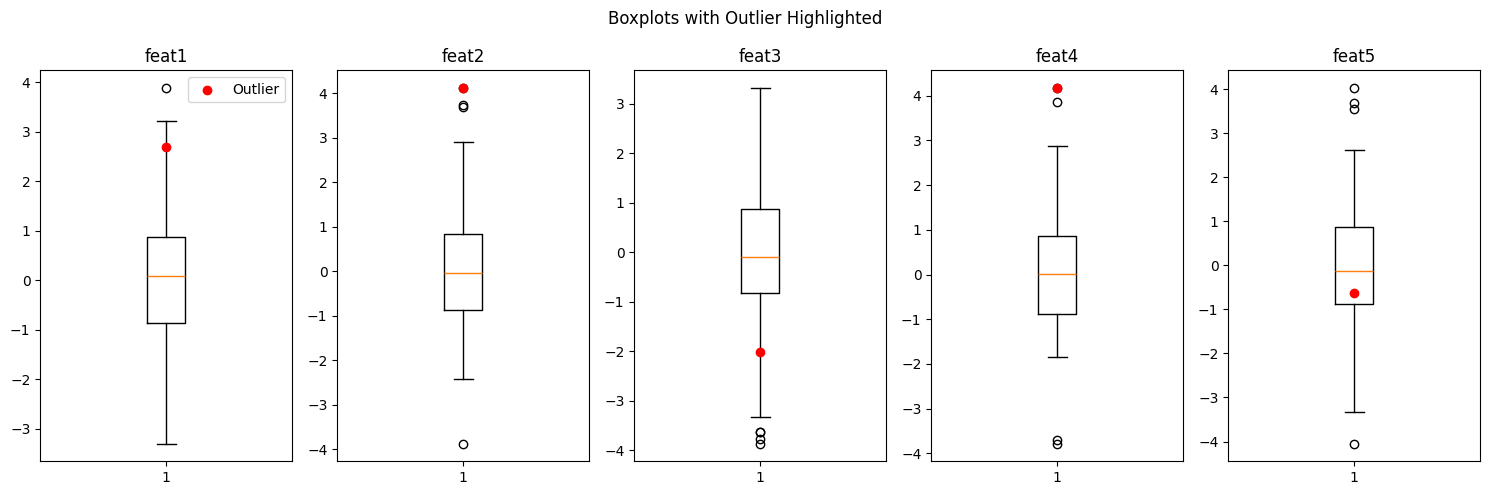

In [ ]:
#@title 4. Boxplots per Feature with Outlier Marker
def plot_boxplots(self, point_idx=None):
    """
    Boxplots for each feature with outlier marker.

    Parameters
    ----------
    point_idx : int, optional
        Outlier index. If None, first outlier is used.
    """
    if not self.fitted:
        raise RuntimeError("Model must be fitted before plotting.")

    if point_idx is None:
        point_idx = self.df_clean[self.df_clean["is_outlier"]].index[0]

    outlier = self.df_clean.loc[point_idx, self.features]

    fig, axes = plt.subplots(1, len(self.features), figsize=(3*len(self.features), 5), sharey=False)
    if len(self.features) == 1:
        axes = [axes]

    for ax, feat in zip(axes, self.features):
        ax.boxplot(self.df_clean[feat], vert=True)
        ax.scatter(1, outlier[feat], color="red", zorder=5, label="Outlier")
        ax.set_title(feat)
    axes[0].legend()
    plt.suptitle("Boxplots with Outlier Highlighted")
    plt.tight_layout()
    plt.show()

import types
kmeans_det.plot_boxplots = types.MethodType(plot_boxplots, kmeans_det)

kmeans_det.plot_boxplots()
